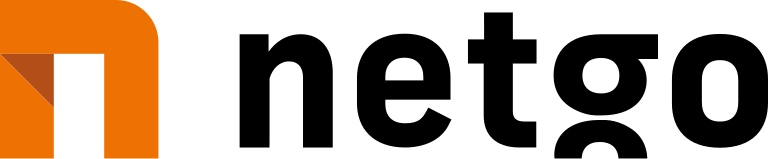

In [1]:
from IPython.display import Image
Image(filename='Netgo_logo.png') 

Statement: In order to analyze the workforce over time, a validity field (effectiveDate) was introduced in our HR software to indicate from when a data record is valid 


-> *Conclusion: effectiveDate will be used to validate data*


Statement: However, retrieving the data via the API is very cumbersome: only one query per employee and timestamp is possible. This is particularly time-consuming when dealing with many employees and frequent changes over time.

-> *Conclusion: In blind spots we assume the extremities shall apply as producing the full chronological development seems cumbersome*

1. We start by installing and importing the necessary libraries and loading the data into dataframes

In [2]:
#Import libraries
import pandas as pd
import datetime

# Load both dataframes
employee_df = pd.read_csv('employees.csv', parse_dates=['effectiveDate'])
employee_ous_df = pd.read_csv('employees_ous.csv', parse_dates=['effectiveDate'])

# Sort by Id and time to gain chronological insights which is very ergonomic
employee_df.sort_values(by=['id', 'effectiveDate'], inplace=True)
employee_ous_df.sort_values(by=['id', 'typeId', 'effectiveDate'], inplace=True)


2. We follow up by basic data exploration

In [3]:
#Exploring the employee data very quickly
employee_df.head(10)

# Not all the data types are correct for example zipCode is seen as a float and not integer we will cast

# It seems there are some duplicates in the data with effectiveDate being the only change data, 
# we will address that by grouping by the columns and keeping max date for each duplicate.

# Timezone is sometimes null even when the address is there. we will fix it using readily available packages. 

,effectiveDate,id,firstName,lastName,prefix,managerId,country,line1,city,zipCode,lastHireDate,originalHireDate,active,absent,timeZone
0,2024-07-03,21045,Nada,Neuschäfer,NaN,NaN,DEU,Herrmannplatz 2,Bad Freienwalde,68523.0,2024-08-01T00:00:00,2024-08-01T00:00:00,True,False,NaN
1,2024-07-12,21045,Nada,Neuschäfer,NaN,NaN,DEU,Herrmannplatz 2,Bad Freienwalde,68523.0,2024-08-01T00:00:00,2024-08-01T00:00:00,True,False,NaN
2,2024-07-30,21045,Nada,Neuschäfer,NaN,NaN,DEU,Herrmannplatz 2,Bad Freienwalde,68523.0,2024-08-01T00:00:00,2024-08-01T00:00:00,True,False,NaN
3,2024-07-31,21045,Nada,Neuschäfer,NaN,2572.0,DEU,Trommlerring 969,Pirmasens,98186.0,2024-08-01T00:00:00,2024-08-01T00:00:00,True,False,NaN
4,2024-08-01,21045,Nada,Neuschäfer,NaN,2572.0,DEU,Trommlerring 969,Pirmasens,98186.0,2024-08-01T00:00:00,2024-08-01T00:00:00,True,False,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto..."
5,2024-08-19,21045,Nada,Neuschäfer,NaN,2572.0,DEU,Trommlerring 969,Pirmasens,98186.0,2024-08-01T00:00:00,2024-08-01T00:00:00,True,False,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto..."
6,2024-09-02,21045,Nada,Neuschäfer,NaN,2572.0,DEU,Ingeburg-Junk-Allee 1,Pirmasens,98186.0,2024-08-01T00:00:00,2024-08-01T00:00:00,True,False,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto..."
7,2024-10-01,21045,Nada,Neuschäfer,NaN,2572.0,DEU,Ingeburg-Junk-Allee 1,Pirmasens,98186.0,2024-08-01T00:00:00,2024-08-01T00:00:00,True,False,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto..."
8,2024-10-23,21045,Nada,Neuschäfer,NaN,2572.0,DEU,Ingeburg-Junk-Allee 1,Pirmasens,98186.0,2024-08-01T00:00:00,2024-08-01T00:00:00,True,False,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto..."
9,2024-11-26,21045,Nada,Neuschäfer,NaN,2572.0,DEU,Ingeburg-Junk-Allee 1,Pirmasens,98186.0,2024-08-01T00:00:00,2024-08-01T00:00:00,True,False,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto..."


Cast employee_df columns into the right datatype to avoid complications

In [4]:
# Cast date columns
date_columns = ['effectiveDate', 'lastHireDate', 'originalHireDate']
for col in date_columns:
    employee_df[col] = pd.to_datetime(employee_df[col])

# Cast integer columns
integer_columns = ['id', 'zipCode', 'managerId']
for col in integer_columns:
    employee_df[col] = pd.to_numeric(employee_df[col], errors='coerce').astype('Int64')  # Using Int64 to handle NaN values

# Cast boolean columns
boolean_columns = ['active', 'absent']
for col in boolean_columns:
    employee_df[col] = employee_df[col].astype(bool)

# Cast remaining columns to string
string_columns = [col for col in employee_df.columns 
                 if col not in date_columns + integer_columns + boolean_columns]
for col in string_columns:
    employee_df[col] = employee_df[col].astype(str)

# Display data types after casting
print("\nDataFrame data types after casting:")
print(employee_df.dtypes) 


DataFrame data types after casting:
effectiveDate       datetime64[ns]
id                           Int64
firstName                   object
lastName                    object
prefix                      object
managerId                    Int64
country                     object
line1                       object
city                        object
zipCode                      Int64
lastHireDate        datetime64[ns]
originalHireDate    datetime64[ns]
active                        bool
absent                        bool
timeZone                    object
dtype: object


In [5]:
# Checking some columns in employee_df to understand how useful they are
employee_df[employee_df['absent']==True].size
# Absent is always false and can be excluded from futher analysis

0

In [6]:
# active column seems to contain releant information
employee_df[employee_df['active']==False].size

420

Unify all location columns into a single string column to lighten groups and joins #efficiency

In [7]:
# We opt to group address information into a single column for cheaper querying in the future
# We are trying to showcase efficiency when needed 
employee_df['address'] = employee_df[['line1', 'zipCode', 'city', 'country']].apply(
    lambda x: f"{x['line1']} {str(x['zipCode'])}, {x['city']}, {x['country']}", 
    axis=1
)
# Drop the address-related columns since we've created a combined address column
columns_to_drop = ['line1', 'zipCode', 'city', 'country', 'absent']
employee_df = employee_df.drop(columns=columns_to_drop)
employee_df.head(10)


,effectiveDate,id,firstName,lastName,prefix,managerId,lastHireDate,originalHireDate,active,timeZone,address
0,2024-07-03,21045,Nada,Neuschäfer,nan,<NA>,2024-08-01,2024-08-01,True,nan,"Herrmannplatz 2 68523, Bad Freienwalde, DEU"
1,2024-07-12,21045,Nada,Neuschäfer,nan,<NA>,2024-08-01,2024-08-01,True,nan,"Herrmannplatz 2 68523, Bad Freienwalde, DEU"
2,2024-07-30,21045,Nada,Neuschäfer,nan,<NA>,2024-08-01,2024-08-01,True,nan,"Herrmannplatz 2 68523, Bad Freienwalde, DEU"
3,2024-07-31,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU"
4,2024-08-01,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU"
5,2024-08-19,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU"
6,2024-09-02,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU"
7,2024-10-01,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU"
8,2024-10-23,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU"
9,2024-11-26,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU"


Grouping by relvant columns to remove duplicates and getting min_date to estimate data freshness

In [8]:
employee_df# Group by specified columns and get min effectiveDate
grouped_employee = employee_df.groupby([
    'id',
    'firstName',
    'lastName',
    'prefix',
    'managerId',
    'lastHireDate',
    'originalHireDate',
    'active',
    'timeZone',
    'address'
]).agg(
    min_effective_date=('effectiveDate', 'min')
    
).reset_index()

# Sort by id and max_effective_date for better readability

grouped_employee = grouped_employee.sort_values(['id', 'min_effective_date'])
grouped_employee.head(10)


,id,firstName,lastName,prefix,managerId,lastHireDate,originalHireDate,active,timeZone,address,min_effective_date
2,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",2024-07-31
1,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2024-08-01
0,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",2024-09-02
6,21104,Iris,Baum,Herr,14452,2024-09-01,2024-09-01,True,nan,"Wendeweg 07 78862, Gunzenhausen, DEU",2024-08-30
5,21104,Iris,Baum,Herr,14452,2024-09-01,2024-09-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Wendeweg 07 78862, Gunzenhausen, DEU",2024-09-01
3,21104,Heinz-Walter,Baum,Herr,14452,2024-09-01,2024-09-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Wendeweg 07 78862, Gunzenhausen, DEU",2024-09-04
4,21104,Heinz-Walter,Baum,Herr,29728,2024-09-01,2024-09-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Wendeweg 07 78862, Gunzenhausen, DEU",2025-01-31
9,21285,Dietlinde,Ruppert,nan,159,2024-08-01,2024-08-01,True,nan,"Kostolzinplatz 928 22682, Kitzingen, DEU",2024-07-31
8,21285,Dietlinde,Ruppert,nan,159,2024-08-01,2024-08-01,True,nan,"Carolin-Freudenberger-Weg 4 13368, Eisenhütten...",2024-12-19
7,21285,Dietlinde,Ruppert,nan,159,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Carolin-Freudenberger-Weg 4 13368, Eisenhütten...",2025-01-23


Generating the rank column to facilitate with joining on rank -1 to obtain ranges

In [9]:
grouped_employee['rank'] = grouped_employee.sort_values(['id', 'min_effective_date']) \
    .groupby(['id'])['min_effective_date'].rank(method='first').astype(int)
grouped_employee.head(10)


,id,firstName,lastName,prefix,managerId,lastHireDate,originalHireDate,active,timeZone,address,min_effective_date,rank
2,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",2024-07-31,1
1,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2024-08-01,2
0,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",2024-09-02,3
6,21104,Iris,Baum,Herr,14452,2024-09-01,2024-09-01,True,nan,"Wendeweg 07 78862, Gunzenhausen, DEU",2024-08-30,1
5,21104,Iris,Baum,Herr,14452,2024-09-01,2024-09-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Wendeweg 07 78862, Gunzenhausen, DEU",2024-09-01,2
3,21104,Heinz-Walter,Baum,Herr,14452,2024-09-01,2024-09-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Wendeweg 07 78862, Gunzenhausen, DEU",2024-09-04,3
4,21104,Heinz-Walter,Baum,Herr,29728,2024-09-01,2024-09-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Wendeweg 07 78862, Gunzenhausen, DEU",2025-01-31,4
9,21285,Dietlinde,Ruppert,nan,159,2024-08-01,2024-08-01,True,nan,"Kostolzinplatz 928 22682, Kitzingen, DEU",2024-07-31,1
8,21285,Dietlinde,Ruppert,nan,159,2024-08-01,2024-08-01,True,nan,"Carolin-Freudenberger-Weg 4 13368, Eisenhütten...",2024-12-19,2
7,21285,Dietlinde,Ruppert,nan,159,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Carolin-Freudenberger-Weg 4 13368, Eisenhütten...",2025-01-23,3


Joining with itself on Id = Id and Rank = Rank - 1 to generate date ranges

In [10]:
# Left copy will remain the same the right copy will contain data from the following row for join
df_left = grouped_employee.copy()
df_right = grouped_employee.copy()[['id', 'min_effective_date', 'rank']] #Dropping unnecessary columns

df_right['rank'] = df_right['rank'] - 1  # So we can merge rows next to each other
df_right['min_effective_date'] = pd.to_datetime(df_right['min_effective_date']) - pd.Timedelta(days=1)

# Merge: match current row with its next row (rank + 1)
merged_employee = df_left.merge(
    df_right,
    on=['id', 'rank'],
    how='left',
    suffixes=('', '_next')
)

#Renaming colums to fit our question
merged_employee = merged_employee.rename(columns = {
    'min_effective_date': 'valid_from',
    'min_effective_date_next': 'valid_to',
    'max_effective_date': 'last_check'})

merged_employee.head(10)

,id,firstName,lastName,prefix,managerId,lastHireDate,originalHireDate,active,timeZone,address,valid_from,rank,valid_to
0,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",2024-07-31,1,2024-07-31
1,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2024-08-01,2,2024-09-01
2,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",2024-09-02,3,NaT
3,21104,Iris,Baum,Herr,14452,2024-09-01,2024-09-01,True,nan,"Wendeweg 07 78862, Gunzenhausen, DEU",2024-08-30,1,2024-08-31
4,21104,Iris,Baum,Herr,14452,2024-09-01,2024-09-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Wendeweg 07 78862, Gunzenhausen, DEU",2024-09-01,2,2024-09-03
5,21104,Heinz-Walter,Baum,Herr,14452,2024-09-01,2024-09-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Wendeweg 07 78862, Gunzenhausen, DEU",2024-09-04,3,2025-01-30
6,21104,Heinz-Walter,Baum,Herr,29728,2024-09-01,2024-09-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Wendeweg 07 78862, Gunzenhausen, DEU",2025-01-31,4,NaT
7,21285,Dietlinde,Ruppert,nan,159,2024-08-01,2024-08-01,True,nan,"Kostolzinplatz 928 22682, Kitzingen, DEU",2024-07-31,1,2024-12-18
8,21285,Dietlinde,Ruppert,nan,159,2024-08-01,2024-08-01,True,nan,"Carolin-Freudenberger-Weg 4 13368, Eisenhütten...",2024-12-19,2,2025-01-22
9,21285,Dietlinde,Ruppert,nan,159,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Carolin-Freudenberger-Weg 4 13368, Eisenhütten...",2025-01-23,3,NaT


In [11]:
# Get today's date using pd.Timestamp
today = pd.Timestamp.now().date()

# Fill null values in valid_to with today's date as last computed active date
merged_employee['valid_to'] = pd.to_datetime(merged_employee['valid_to'].fillna(today))

#Quick data quality check
merged_employee.head(10)

,id,firstName,lastName,prefix,managerId,lastHireDate,originalHireDate,active,timeZone,address,valid_from,rank,valid_to
0,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",2024-07-31,1,2024-07-31
1,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2024-08-01,2,2024-09-01
2,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",2024-09-02,3,2025-06-17
3,21104,Iris,Baum,Herr,14452,2024-09-01,2024-09-01,True,nan,"Wendeweg 07 78862, Gunzenhausen, DEU",2024-08-30,1,2024-08-31
4,21104,Iris,Baum,Herr,14452,2024-09-01,2024-09-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Wendeweg 07 78862, Gunzenhausen, DEU",2024-09-01,2,2024-09-03
5,21104,Heinz-Walter,Baum,Herr,14452,2024-09-01,2024-09-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Wendeweg 07 78862, Gunzenhausen, DEU",2024-09-04,3,2025-01-30
6,21104,Heinz-Walter,Baum,Herr,29728,2024-09-01,2024-09-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Wendeweg 07 78862, Gunzenhausen, DEU",2025-01-31,4,2025-06-17
7,21285,Dietlinde,Ruppert,nan,159,2024-08-01,2024-08-01,True,nan,"Kostolzinplatz 928 22682, Kitzingen, DEU",2024-07-31,1,2024-12-18
8,21285,Dietlinde,Ruppert,nan,159,2024-08-01,2024-08-01,True,nan,"Carolin-Freudenberger-Weg 4 13368, Eisenhütten...",2024-12-19,2,2025-01-22
9,21285,Dietlinde,Ruppert,nan,159,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Carolin-Freudenberger-Weg 4 13368, Eisenhütten...",2025-01-23,3,2025-06-17


Starting with Analysis of employee_ous_df data

In [12]:
#Exploring the employee_ous data very quickly
employee_ous_df.sort_values(by=['id', 'effectiveDate'], inplace=True)
employee_ous_df.head(10)

# We notice that the very same Id has multiple rows with the same effectiveDate but 
# multiple ous and TypeId. We can already conclude that this table tracks changes
# in the employee data over time. And there seems to be a correlation between ous and TypeId.
# The most likely explanation is that typeId secifies the type of data changed and ous its value

,id,effectiveDate,ous,typeId
0,21045,2024-07-03,522,Organisation
1,21045,2024-07-03,743,Position
2,21045,2024-07-03,413,Standort
3,21045,2024-07-12,522,Organisation
4,21045,2024-07-12,743,Position
5,21045,2024-07-12,413,Standort
6,21045,2024-07-30,522,Organisation
7,21045,2024-07-30,743,Position
8,21045,2024-07-30,413,Standort
9,21045,2024-07-31,868,Organisation


In [13]:
# We need to explore the relationship between ous and typeId
# Group by type and calculate row count and count of unique ous
# It seems that there are 4 different typeIds and each has many associated ous
analysis = employee_ous_df.groupby('typeId').agg(
    total_rows=('typeId', 'count'),
    unique_ous=('ous', 'nunique')
).reset_index()

analysis

,typeId,total_rows,unique_ous
0,Job-Familie,436,9
1,Organisation,936,72
2,Position,597,35
3,Standort,1080,35


In [14]:
# Group by type and calculate row count and count of unique typeId
# Each ous seems to have a single possible value of type_id. 
# We can confirm quickly by calling .unique() for this column
analysis = employee_ous_df.groupby('ous').agg(
    total_rows=('ous', 'count'),
    type_ids=('typeId', 'nunique')
).reset_index()

analysis

,ous,total_rows,type_ids
0,81,4,1
1,117,8,1
2,144,1,1
3,150,1,1
4,155,1,1
...,...,...,...
146,2839,10,1
147,2853,11,1
148,2857,15,1
149,2883,4,1


In [15]:
# We cofirmed that for each ous there can only be a single type_id value which confirms the connection
# between these two columns. The most likely explanation is that ous seem to be different possible values
# for the 4 types extracted. 
# From this point on, given the limited information provided about what ous is we will assume the above 
# to be true for this analysis. 
analysis['type_ids'].unique()

array([1])

In [16]:
#Filtering for a secific case to prove our conclusion. Indeed TypeID = Job-Familie has 9 possible ous values
employee_ous_df[employee_ous_df['typeId'] == 'Job-Familie']['ous'].unique()

array([2708, 2710, 2711, 2706, 2707, 2702, 2704, 2703, 2709])

In [17]:
#Filtering for a secific case to prove our conclusion. Indeed ous 2708 has only one TypeID = Job-Familie
employee_ous_df[employee_ous_df['ous'] == 2708]['typeId'].unique()

array(['Job-Familie'], dtype=object)

In [18]:
# However some data from employee_ous_df seems to hold some unnecessary duplication with multiple dates
# referring to no change in the ous within the typeId. For example: 

subset = employee_ous_df.query('id == 21045 & typeId == "Organisation"')
subset.sort_values(by=['effectiveDate'])

# As such we will opt to group by id, ous and typeId and get min and max dates to get life time of each 
# ous value for each employee 



,id,effectiveDate,ous,typeId
0,21045,2024-07-03,522,Organisation
3,21045,2024-07-12,522,Organisation
6,21045,2024-07-30,522,Organisation
9,21045,2024-07-31,868,Organisation
12,21045,2024-08-01,868,Organisation
15,21045,2024-08-19,868,Organisation
18,21045,2024-09-02,868,Organisation
21,21045,2024-10-01,868,Organisation
24,21045,2024-10-23,868,Organisation
28,21045,2024-11-26,868,Organisation


In [19]:
#Another filter to check validity of theory about data
employee_ous_df[(employee_ous_df['id'] == 21045) & (employee_ous_df['typeId'] == 'Organisation')]

,id,effectiveDate,ous,typeId
0,21045,2024-07-03,522,Organisation
3,21045,2024-07-12,522,Organisation
6,21045,2024-07-30,522,Organisation
9,21045,2024-07-31,868,Organisation
12,21045,2024-08-01,868,Organisation
15,21045,2024-08-19,868,Organisation
18,21045,2024-09-02,868,Organisation
21,21045,2024-10-01,868,Organisation
24,21045,2024-10-23,868,Organisation
28,21045,2024-11-26,868,Organisation


Grouping by the 3 relevant columns to remove duplicates and enerating min and max dates of effect

In [20]:
# Group by id, typeId, and ous and calculate min/max effective dates
grouped_analysis = employee_ous_df.groupby(['id', 'typeId', 'ous']).agg(
    min_effective_date=('effectiveDate', 'min'),
    max_effective_date=('effectiveDate', 'max')
).reset_index()

grouped_analysis[grouped_analysis['id'] == 21045]

# We managed to capture first and last recorded date for a specific ous value in an employee's data
# However, checking from the example below. An ous real lifetime  extends beyond max_effective_date 
# the real lifetime of an ous extends to include 1 day before the detection of a new ous for the same typeId

,id,typeId,ous,min_effective_date,max_effective_date
0,21045,Job-Familie,2708,2024-10-23,2025-03-27
1,21045,Job-Familie,2710,2025-04-01,2025-04-25
2,21045,Organisation,522,2024-07-03,2024-07-30
3,21045,Organisation,868,2024-07-31,2025-04-25
4,21045,Position,743,2024-07-03,2025-04-25
5,21045,Standort,413,2024-07-03,2025-04-25


Generate rank column over Id and TypeID to facilitate joining table on itself

In [21]:
# We will add a rank column that orders rows according to partition of id, typeId sorted by min_effective_date
grouped_analysis['rank'] = grouped_analysis.sort_values('min_effective_date') \
    .groupby(['id', 'typeId'])['min_effective_date'].rank(method='first').astype(int)

grouped_analysis[grouped_analysis['id'] == 21045]

,id,typeId,ous,min_effective_date,max_effective_date,rank
0,21045,Job-Familie,2708,2024-10-23,2025-03-27,1
1,21045,Job-Familie,2710,2025-04-01,2025-04-25,2
2,21045,Organisation,522,2024-07-03,2024-07-30,1
3,21045,Organisation,868,2024-07-31,2025-04-25,2
4,21045,Position,743,2024-07-03,2025-04-25,1
5,21045,Standort,413,2024-07-03,2025-04-25,1


Joining the table on itself on Id, TypeId and rank = rank -1 to obtain full range of validity of data point

In [22]:
# Left copy will remain the same the right copy will contain data from the following row for join
df_left = grouped_analysis.copy()
df_right = grouped_analysis.copy().drop(['ous', 'max_effective_date'], axis=1) #Dropping unnecessary columns

df_right['rank'] = df_right['rank'] - 1  # So we can merge rows next to each other
df_right['min_effective_date'] = pd.to_datetime(df_right['min_effective_date']) - pd.Timedelta(days=1)

# Merge: match current row with its next row (rank + 1)
merged = df_left.merge(
    df_right,
    on=['id', 'typeId', 'rank'],
    how='left',
    suffixes=('', '_next')
)

#Renaming colums to fit our question
merged = merged.rename(columns = {
    'min_effective_date': 'valid_from',
    'min_effective_date_next': 'valid_to',
    'max_effective_date': 'last_check'})

merged[merged['id'] == 21045]

,id,typeId,ous,valid_from,last_check,rank,valid_to
0,21045,Job-Familie,2708,2024-10-23,2025-03-27,1,2025-03-31
1,21045,Job-Familie,2710,2025-04-01,2025-04-25,2,NaT
2,21045,Organisation,522,2024-07-03,2024-07-30,1,2024-07-30
3,21045,Organisation,868,2024-07-31,2025-04-25,2,NaT
4,21045,Position,743,2024-07-03,2025-04-25,1,NaT
5,21045,Standort,413,2024-07-03,2025-04-25,1,NaT


Filling out NAN values in valid_to with today's value to ensure easy join of table

In [23]:
# Get today's date using pd.Timestamp
today = pd.Timestamp.now().date()

# Fill null values in valid_to with today's date as last computed active date
merged['valid_to'] = pd.to_datetime(merged['valid_to'].fillna(today))

#Quick data quality check
merged[merged['id'] == 21045]

,id,typeId,ous,valid_from,last_check,rank,valid_to
0,21045,Job-Familie,2708,2024-10-23,2025-03-27,1,2025-03-31
1,21045,Job-Familie,2710,2025-04-01,2025-04-25,2,2025-06-17
2,21045,Organisation,522,2024-07-03,2024-07-30,1,2024-07-30
3,21045,Organisation,868,2024-07-31,2025-04-25,2,2025-06-17
4,21045,Position,743,2024-07-03,2025-04-25,1,2025-06-17
5,21045,Standort,413,2024-07-03,2025-04-25,1,2025-06-17


In [24]:
#Reminder of what merged_employee looks like
merged_employee[merged_employee['id'] == 21045]

,id,firstName,lastName,prefix,managerId,lastHireDate,originalHireDate,active,timeZone,address,valid_from,rank,valid_to
0,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",2024-07-31,1,2024-07-31
1,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2024-08-01,2,2024-09-01
2,21045,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",2024-09-02,3,2025-06-17


Joining both tables on ID to generate all different possibilities of date overlaps

In [25]:
# We will now left join merged to our grouped employee table to generate the employee metadata in 1 central table
# We still have multiple entries for each employee id in both tables. As such we will count rows before and after
# merge to ensure sound join logic. 
cross_join_table = merged.merge(
    merged_employee,
    on='id',
    how='outer',
    suffixes=('', '_next')
)

cross_join_table.drop(['last_check', 'rank', 'rank_next'], axis=1)

cross_join_table[cross_join_table['id'] == 21045]

,id,typeId,ous,valid_from,last_check,rank,valid_to,firstName,lastName,prefix,managerId,lastHireDate,originalHireDate,active,timeZone,address,valid_from_next,rank_next,valid_to_next
0,21045,Job-Familie,2708,2024-10-23,2025-03-27,1,2025-03-31,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",2024-07-31,1.0,2024-07-31
1,21045,Job-Familie,2708,2024-10-23,2025-03-27,1,2025-03-31,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2024-08-01,2.0,2024-09-01
2,21045,Job-Familie,2708,2024-10-23,2025-03-27,1,2025-03-31,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",2024-09-02,3.0,2025-06-17
3,21045,Job-Familie,2710,2025-04-01,2025-04-25,2,2025-06-17,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",2024-07-31,1.0,2024-07-31
4,21045,Job-Familie,2710,2025-04-01,2025-04-25,2,2025-06-17,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2024-08-01,2.0,2024-09-01
5,21045,Job-Familie,2710,2025-04-01,2025-04-25,2,2025-06-17,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",2024-09-02,3.0,2025-06-17
6,21045,Organisation,522,2024-07-03,2024-07-30,1,2024-07-30,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",2024-07-31,1.0,2024-07-31
7,21045,Organisation,522,2024-07-03,2024-07-30,1,2024-07-30,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2024-08-01,2.0,2024-09-01
8,21045,Organisation,522,2024-07-03,2024-07-30,1,2024-07-30,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",2024-09-02,3.0,2025-06-17
9,21045,Organisation,868,2024-07-31,2025-04-25,2,2025-06-17,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",2024-07-31,1.0,2024-07-31


Moving all date columns to the last 4 positions for clarity

In [26]:
# List of columns to move
cols_to_move = ['valid_from', 'valid_to', 'valid_from_next', 'valid_to_next']

# All columns in the DataFrame
all_cols = list(cross_join_table.columns)

# Reorder: put the rest first, then the selected ones
new_order = [col for col in all_cols if col not in cols_to_move] + cols_to_move

# Reassign with new column order
cross_join_table = cross_join_table[new_order]
cross_join_table[cross_join_table['id'] == 21045]

,id,typeId,ous,last_check,rank,firstName,lastName,prefix,managerId,lastHireDate,originalHireDate,active,timeZone,address,rank_next,valid_from,valid_to,valid_from_next,valid_to_next
0,21045,Job-Familie,2708,2025-03-27,1,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",1.0,2024-10-23,2025-03-31,2024-07-31,2024-07-31
1,21045,Job-Familie,2708,2025-03-27,1,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2.0,2024-10-23,2025-03-31,2024-08-01,2024-09-01
2,21045,Job-Familie,2708,2025-03-27,1,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",3.0,2024-10-23,2025-03-31,2024-09-02,2025-06-17
3,21045,Job-Familie,2710,2025-04-25,2,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",1.0,2025-04-01,2025-06-17,2024-07-31,2024-07-31
4,21045,Job-Familie,2710,2025-04-25,2,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2.0,2025-04-01,2025-06-17,2024-08-01,2024-09-01
5,21045,Job-Familie,2710,2025-04-25,2,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",3.0,2025-04-01,2025-06-17,2024-09-02,2025-06-17
6,21045,Organisation,522,2024-07-30,1,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",1.0,2024-07-03,2024-07-30,2024-07-31,2024-07-31
7,21045,Organisation,522,2024-07-30,1,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2.0,2024-07-03,2024-07-30,2024-08-01,2024-09-01
8,21045,Organisation,522,2024-07-30,1,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",3.0,2024-07-03,2024-07-30,2024-09-02,2025-06-17
9,21045,Organisation,868,2025-04-25,2,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",1.0,2024-07-31,2025-06-17,2024-07-31,2024-07-31


Filtering for overlapping timeframes only. To simplify the solution and stick to proveable data

In [27]:
filtered_df = cross_join_table[
    (cross_join_table["valid_from"] <= cross_join_table["valid_to_next"]) &
    (cross_join_table["valid_to"] >= cross_join_table["valid_from_next"])
].copy()

filtered_df[filtered_df['id'] == 21045]

,id,typeId,ous,last_check,rank,firstName,lastName,prefix,managerId,lastHireDate,originalHireDate,active,timeZone,address,rank_next,valid_from,valid_to,valid_from_next,valid_to_next
2,21045,Job-Familie,2708,2025-03-27,1,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",3.0,2024-10-23,2025-03-31,2024-09-02,2025-06-17
5,21045,Job-Familie,2710,2025-04-25,2,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",3.0,2025-04-01,2025-06-17,2024-09-02,2025-06-17
9,21045,Organisation,868,2025-04-25,2,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",1.0,2024-07-31,2025-06-17,2024-07-31,2024-07-31
10,21045,Organisation,868,2025-04-25,2,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2.0,2024-07-31,2025-06-17,2024-08-01,2024-09-01
11,21045,Organisation,868,2025-04-25,2,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",3.0,2024-07-31,2025-06-17,2024-09-02,2025-06-17
12,21045,Position,743,2025-04-25,1,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",1.0,2024-07-03,2025-06-17,2024-07-31,2024-07-31
13,21045,Position,743,2025-04-25,1,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2.0,2024-07-03,2025-06-17,2024-08-01,2024-09-01
14,21045,Position,743,2025-04-25,1,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",3.0,2024-07-03,2025-06-17,2024-09-02,2025-06-17
15,21045,Standort,413,2025-04-25,1,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",1.0,2024-07-03,2025-06-17,2024-07-31,2024-07-31
16,21045,Standort,413,2025-04-25,1,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2.0,2024-07-03,2025-06-17,2024-08-01,2024-09-01


Selecting smallest timeframe on each row to obtain most granular


In [28]:
filtered_df["valid_from"] = filtered_df[["valid_from", "valid_from_next"]].max(axis=1)
filtered_df["valid_to"] = filtered_df[["valid_to", "valid_to_next"]].min(axis=1)

# Drop helper columns if needed
filtered_df = filtered_df.drop(columns=["valid_from_next", "valid_to_next", "rank", "rank_next"])

# Optional: sort
final_df = filtered_df.sort_values(by=["id", "valid_from"])
final_df[final_df['id']==21045]

,id,typeId,ous,last_check,firstName,lastName,prefix,managerId,lastHireDate,originalHireDate,active,timeZone,address,valid_from,valid_to
9,21045,Organisation,868,2025-04-25,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",2024-07-31,2024-07-31
12,21045,Position,743,2025-04-25,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",2024-07-31,2024-07-31
15,21045,Standort,413,2025-04-25,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,nan,"Trommlerring 969 98186, Pirmasens, DEU",2024-07-31,2024-07-31
10,21045,Organisation,868,2025-04-25,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2024-08-01,2024-09-01
13,21045,Position,743,2025-04-25,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2024-08-01,2024-09-01
16,21045,Standort,413,2025-04-25,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Trommlerring 969 98186, Pirmasens, DEU",2024-08-01,2024-09-01
11,21045,Organisation,868,2025-04-25,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",2024-09-02,2025-06-17
14,21045,Position,743,2025-04-25,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",2024-09-02,2025-06-17
17,21045,Standort,413,2025-04-25,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",2024-09-02,2025-06-17
2,21045,Job-Familie,2708,2025-03-27,Nada,Neuschäfer,nan,2572,2024-08-01,2024-08-01,True,"(UTC+01:00) Amsterdam, Berlin, Bern, Rome, Sto...","Ingeburg-Junk-Allee 1 98186, Pirmasens, DEU",2024-10-23,2025-03-31


In [31]:
final_df.to_csv('hr_final_table.csv')